In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import make_scorer, mean_squared_error,mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [6]:
def get_time(filename):
    values = filename.split("_")
    for t_value in values:
        if t_value in ['2','4','6','8','10','12']:
            # print(t_value)
            return int(t_value)
    return None

def get_total():
    total = 0
    for file in sorted(os.listdir(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_constant_flux/csvfiles'), key=len):
        total+=len(os.listdir(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_constant_flux/csvfiles/{file}')) 
    return total

In [7]:
features_col = ['Arflux','Fflux',
            'ArExponent','FrExponent',
            'yield_at_zero1','yield_at_zero2','yield_at_zero3',
            'yield_max1','yield_max2','yield_max3',
            'theta_max1','theta_max2','theta_max3','mizk',
            'p1','p2','p3','p4','p5']

In [8]:
df_final = pd.DataFrame()
# valid_df_final = pd.DataFrame()
test_df_final = pd.DataFrame()

test_file_num = 0
turn = 1

total  = get_total()

test_size = int(0.2*total)

for folder in sorted(os.listdir(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_constant_flux/csvfiles'), key=len):

    # sorting file acc to len so that t= 10,12 gets to its original pos
    for file in sorted(os.listdir(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_constant_flux/csvfiles/{folder}'), key=len):

        input_values = file.split('_')[1:-3]
        input_values = [float(item) for item in input_values]
        if(turn <= 8):
            df = pd.read_csv(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_constant_flux/csvfiles/{folder}/{file}')

        #dropping rows with zero valies in it
            zero_values_row_index = df[df['FitRadius_Avg']==0].index
            df = df.drop(zero_values_row_index)
            indexes_of_not_silicon = df[df['Z']>=0.000].index
            df = df.drop(indexes_of_not_silicon)

            df['Z'] = df['Z'].apply(lambda x: round(x,4))

            new_col_names = ['Z','avg fitradius', 'time']
            new_row_values =  [-df['Z'].iloc[0], df['FitRadius_Avg'].mean(), get_time(file)]
            new_df = pd.DataFrame([new_row_values],columns=new_col_names)

            for i in range(len(input_values)):
                    # print(features_col[i], input_values[i])
                new_df[features_col[i]] = input_values[i]
            df_final = pd.concat([df_final,new_df])   
            turn+=1

        else:
            test_file_num+=1

            test_df = pd.read_csv(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_constant_flux/csvfiles/{folder}/{file}')

            #dropping rows with zero valies in it
            zero_values_row_index = test_df[test_df['FitRadius_Avg']==0].index
            test_df = test_df.drop(zero_values_row_index)
            indexes_of_not_silicon = test_df[test_df['Z']>=0.000].index
            test_df = test_df.drop(indexes_of_not_silicon)

            test_df['Z'] = test_df['Z'].apply(lambda x: round(x,4))

            new_col_names = ['Z','avg fitradius', 'time']
            new_row_values =  [-test_df['Z'].iloc[0], test_df['FitRadius_Avg'].mean(), get_time(file)]
            new_df = pd.DataFrame([new_row_values],columns=new_col_names)

            for i in range(len(input_values)):
                    # print(features_col[i], input_values[i])
                new_df[features_col[i]] = input_values[i]
            test_df_final = pd.concat([test_df_final,new_df])    

            if turn==9: turn+=1
            else: turn = 1

In [5]:
x_train = df_final.loc[:, ~df_final.columns.isin(['avg fitradius', 'Z'])] #removing time as well right now
y_train = df_final[['Z']]
# x_valid = valid_df_final.loc[:, ~valid_df_final.columns.isin(['Z','avg fitradius'])]
# y_valid = valid_df_final[['Z']]
y_test = test_df_final[['Z']]
x_test = test_df_final.drop(['avg fitradius','Z'], axis=1)

In [6]:
from tensorflow.keras import backend as K

def relative_mean_absolute_error(y_true, y_pred):
    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate Mean Absolute Error (MAE)
    rmae = np.abs(y_true - y_pred)
    rmae = np.mean(rmae/y_true)
    
    return rmae

def custom_mae(y_true, y_pred):
    return relative_mean_absolute_error(y_true, y_pred)

def custom_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

In [7]:
# from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler_x_train = StandardScaler()
X_scale_arr = scaler_x_train.fit_transform(x_train)
df_scaledX = pd.DataFrame(X_scale_arr, columns=x_train.columns)


scaler_x_test = StandardScaler()
X_scale_t_arr = scaler_x_test.fit_transform(x_test)
df_scaledX_t = pd.DataFrame(X_scale_t_arr, columns=x_test.columns)

y_train_scale = y_train*100000
y_test_scale = y_test*100000

X_train_scaled_reshaped = X_scale_arr.reshape(X_scale_arr.shape[0],1,X_scale_arr.shape[1])
X_train_scaled_reshaped.shape

X_test_scaled_reshaped = X_scale_t_arr.reshape(X_scale_t_arr.shape[0],1,X_scale_t_arr.shape[1])
X_test_scaled_reshaped.shape


(1862, 1, 20)

In [ ]:
# #Fully Conn. ANN
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Input
# from tensorflow.keras.callbacks import EarlyStopping

# def custom_loss_function(y_true, y_pred):
#     error = K.abs(y_true - y_pred)
#     error = error / y_true
#     loss = K.mean(error)
#     return loss

# def create_ann_model(input_shape):
#     model = Sequential()
#     model.add(Input(shape=(input_shape,)))
#     # model.add(Conv1D(filters=1, kernel_size=6, data_format="channels_first", activation='relu'))
#     model.add(Dense(1024, activation='relu'))
#     # model.add(Dropout(0.5))
#     model.add(Dense(512, activation='relu'))
#     # model.add(Dropout(0.5))
#     # model.add(Dense(250,activation='relu'))
#     # model.add(Dropout(0.5))    
#     model.add(Dense(256, activation='relu'))
#     # model.add(Dropout(0.4))
#     model.add(Dense(128, activation='relu'))
#     # model.add(Dropout(0.4))
#     model.add(Dense(64, activation='relu'))
#     # model.add(Dropout(0.3))
#     # model.add(Dense(50, activation='relu'))
#     # model.add(Dropout(0.2))
#     # model.add(Dense(32, activation='relu'))
#     # model.add(Dense(16, activation='relu'))
#     model.add(Dropout(0.05))
#     model.add(Dense(1))  # Assuming 1 target variable
#     model.compile(optimizer='adam', loss='mape')
#     return model

# # Assuming X_train_scaled_reshaped and X_test_scaled_reshaped are 2D arrays
# # and the input shape is the number of features
# input_shape = (X_scale_arr.shape[1])

# model = create_ann_model(input_shape=input_shape)
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001, verbose=1)

# history = model.fit(X_scale_arr, y_train_scale, epochs=1000, batch_size=64, verbose=1, 
#                     validation_data=(X_scale_t_arr, y_test_scale), 
#                     # callbacks=[early_stopping]
#                     )

# # Predict on the test set
# y_pred = model.predict(X_scale_t_arr)

# print(f'Loss:{relative_mean_absolute_error(y_test_scale, y_pred)}')

Epoch 1/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 76.1931 - val_loss: 22.4414
Epoch 2/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 22.5137 - val_loss: 20.6962
Epoch 3/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 20.2047 - val_loss: 19.3512
Epoch 4/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.9477 - val_loss: 19.2439
Epoch 5/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 17.0994 - val_loss: 16.5818
Epoch 6/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15.3918 - val_loss: 15.0885
Epoch 7/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 14.1111 - val_loss: 14.0580
Epoch 8/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 12.9794 - val_loss: 13.8345
Epoch 9/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 12.1518 - val_loss: 12.7467
Epoch 10/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 11.2405 - val_loss: 11.5494
Epoch 11/1000
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.6911 - val_loss: 11.3695
E

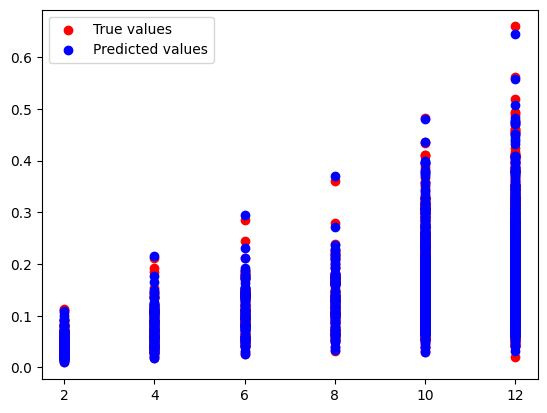

In [ ]:
# plt.scatter(x_test.iloc[:,0],y_test.iloc[:,0],c='red',label=f'True values')
# plt.scatter(x_test.iloc[:,0],y_pred[:,0]/100000,c='blue',label=f'Predicted values')
# plt.legend()
# # plt.ylim(0.02, 0.1)

In [111]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

def create_rnn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    # model.add(SimpleRNN(2048, return_sequences=True, activation='relu'))
    # model.add(SimpleRNN(4096, return_sequences=True, activation='relu'))
    model.add(SimpleRNN(2048, return_sequences=True, activation='relu'))
    model.add(SimpleRNN(1024, return_sequences=True, activation='relu'))
    model.add(SimpleRNN(512, return_sequences=True, activation='relu'))
    model.add(SimpleRNN(256, return_sequences=True, activation='relu'))
    # model.add(Dropout(0.3))
    model.add(SimpleRNN(128, return_sequences=True, activation='relu'))
    model.add(SimpleRNN(64, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(1))  # Assuming 1 target variable
    model.compile(optimizer='adam', loss='mape')
    return model

# Assuming X_train_scaled_reshaped and X_test_scaled_reshaped are 3D arrays
# and the input shape is (time_steps, number of features)
input_shape = (X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2])

model = create_rnn_model(input_shape=input_shape)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, min_delta=0.0001, verbose=1)

history = model.fit(X_train_scaled_reshaped, y_train_scale, epochs=500, batch_size=128, verbose=1, 
                    validation_data=(X_test_scaled_reshaped, y_test_scale), 
                    # callbacks=[early_stopping]
                    )

# Predict on the test set
y_pred = model.predict(X_test_scaled_reshaped)

print(f'Loss: {relative_mean_absolute_error(y_test_scale, y_pred)}')

Epoch 1/500
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - loss: 82.5198 - val_loss: 23.1775
Epoch 2/500
25/59 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: 23.8145

KeyboardInterrupt: 

In [92]:
y_pred = model.predict(X_test_scaled_reshaped)

print(f'Loss: {relative_mean_absolute_error(y_test_scale, y_pred)}')

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
Loss: 0.09431780195050354


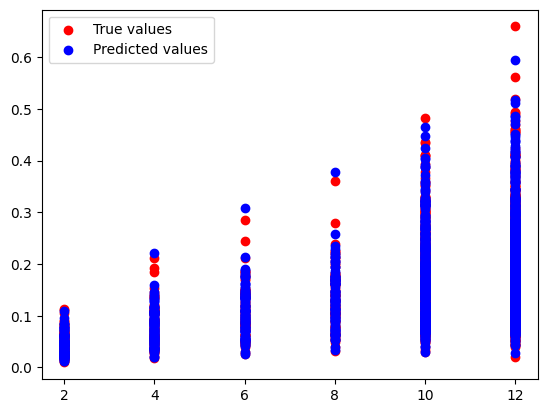

In [106]:
plt.scatter(x_test.iloc[:,0],y_test.iloc[:,0],c='red',label=f'True values')
plt.scatter(x_test.iloc[:,0],y_pred[:,0]/100000,c='blue',label=f'Predicted values')
plt.legend()


In [107]:
y_pred

array([[ 3115.1157],
       [ 6315.3184],
       [ 2194.1462],
       ...,
       [23937.264 ],
       [17395.139 ],
       [14804.008 ]], dtype=float32)

In [108]:
rmae = []
for i in range(len(y_test)):
    # plt.figure()
    # plt.scatter(x_test.iloc[i:i+1,0],y_test.iloc[i:i+1,0],c='red',label=f'True values')
    rmae.append(abs((y_pred[i:i+1,0]/100000-y_test.iloc[i:i+1,0])/y_test.iloc[i:i+1,0]))
    # plt.scatter(i,(y_pred[i:i+1,0]/100000-y_test.iloc[i:i+1,0])/y_test.iloc[i:i+1,0],c='red',label=f'True values')

    # plt.scatter(x_test.iloc[i:i+1,0],y_pred[i:i+1,0]/100000,c='blue',label=f'Predicted values')
    # plt.legend()
# plt.ylim(0.02, 0.1)
rmae = np.array(rmae)

In [109]:
count = 0
for i in rmae:
    if i<=0.2:
        count+=1
len(rmae) - count

100

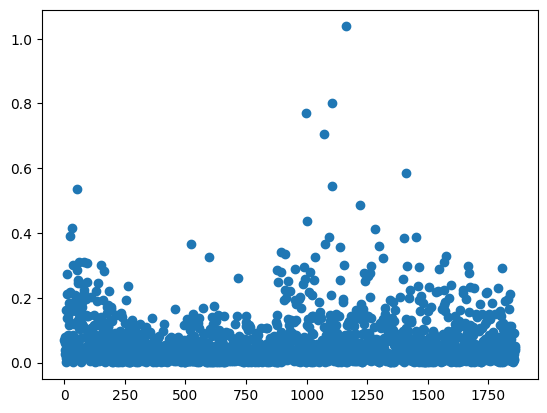

In [110]:
len_rmae = [x for x in range(0,len(rmae))]
plt.scatter(len_rmae, rmae)
# plt.ylim(0,0.3)